In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32
sns.set_context('notebook')

## Toy Model Example

### Make Joint

In [56]:
x = np.array([1., 1.])
i = tf.keras.Input((1,))
l = maxentep.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.Normal(loc=x[...,0], scale=tf.math.exp(x[...,1])))(l)

In [57]:
model = maxentep.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.Adam(0.1))
model.summary()

Model: "parameter_joint_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
trainable_input_layer_2 (Tra (None, 2)                 2         
_________________________________________________________________
distribution_lambda_2 (Distr ((None,), (None,))        0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [58]:
model(tf.constant([1.]))

<tfp.distributions.Normal 'parameter_joint_2_distribution_lambda_2_Normal' batch_shape=[1] event_shape=[] dtype=float32>

In [59]:
def simulate(x):
    y = np.random.normal(loc=x, scale=0.1)
    return y

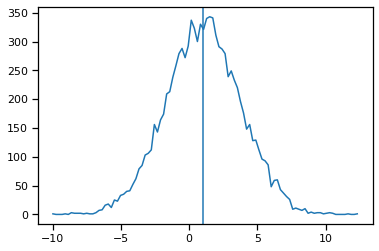

In [60]:
unbiased_params = model.sample(10000)
y = simulate(*unbiased_params)
grid,bins = np.histogram(y, bins=100)
plt.plot((bins[1:] + bins[:-1]) / 2, grid)
plt.axvline(np.mean(np.squeeze(y)))

## Make Constraints

In [66]:
r = maxentep.Restraint(lambda x: x, -5, maxentep.EmptyPrior())

## Maxent without biasing

In [67]:
me_model = maxentep.MaxentModel([r])
me_model.compile(tf.keras.optimizers.Adam(0.01), 'mean_squared_error')
me_model.fit(y, epochs=4)

Epoch 1/4
313/313 [==============================] - 0s 629us/step - loss: 7.6702
Epoch 2/4
313/313 [==============================] - 0s 588us/step - loss: 3.4158
Epoch 3/4
313/313 [==============================] - 0s 602us/step - loss: 2.9423
Epoch 4/4
313/313 [==============================] - 0s 671us/step - loss: 2.7056


In [68]:
np.sum(np.squeeze(y) * me_model.traj_weights)

-9.30418

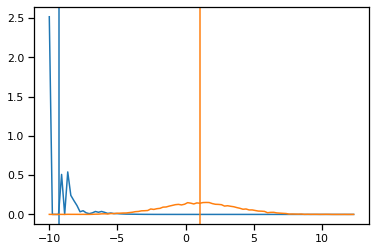

In [69]:
grid,bins = np.histogram(np.squeeze(y), bins=100, weights=me_model.traj_weights, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid)
plt.axvline(np.sum(np.squeeze(y) * me_model.traj_weights))

grid,bins = np.histogram(np.squeeze(y), bins=100, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C1')
plt.axvline(np.mean(np.squeeze(y)), color='C1')

In [70]:
hme_model = maxentep.HyperMaxentModel([r], model, simulate)
hme_model.compile(tf.keras.optimizers.Adam(0.01), 'mean_squared_error')
hme_model.fit(epochs=4)

Epoch 1/4
8/8 [==============================] - 0s 748us/step - loss: 32.9247
Epoch 2/4
8/8 [==============================] - 0s 750us/step - loss: 27.3594
Epoch 3/4
8/8 [==============================] - 0s 875us/step - loss: 22.9656
Epoch 4/4
8/8 [==============================] - 0s 750us/step - loss: 17.2681
Epoch 1/4
8/8 [==============================] - 0s 749us/step - loss: 0.3356
Epoch 2/4
8/8 [==============================] - 0s 625us/step - loss: 0.3197
Epoch 3/4
8/8 [==============================] - 0s 625us/step - loss: 0.3115
Epoch 4/4
8/8 [==============================] - 0s 625us/step - loss: 0.3064
Epoch 1/4
8/8 [==============================] - 0s 625us/step - loss: 14.9252
Epoch 2/4
8/8 [==============================] - 0s 625us/step - loss: 11.5181
Epoch 3/4
8/8 [==============================] - 0s 750us/step - loss: 9.0429
Epoch 4/4
8/8 [==============================] - 0s 625us/step - loss: 6.7568
Epoch 1/4
8/8 [==============================] - 0s 718us/

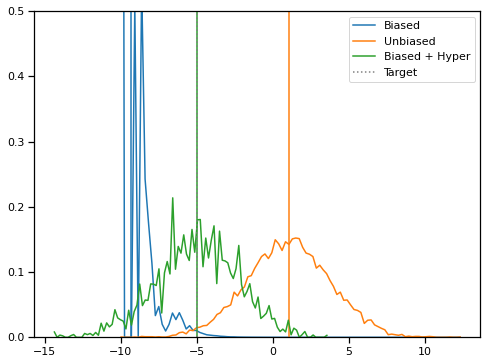

In [74]:
plt.figure(figsize=(8,6))
grid,bins = np.histogram(np.squeeze(y), bins=100, weights=me_model.traj_weights, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, label='Biased')
plt.axvline(np.sum(np.squeeze(y) * me_model.traj_weights))

grid,bins = np.histogram(np.squeeze(y), bins=100, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C1', label='Unbiased')
plt.axvline(np.mean(np.squeeze(y)), color='C1')

yp = np.squeeze(hme_model.trajs)
grid,bins = np.histogram(yp, bins=100, density=True, weights=hme_model.traj_weights)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C2', label='Biased + Hyper')
plt.axvline(np.sum(np.squeeze(yp) * hme_model.traj_weights), color='C2')

plt.axvline(x=r.target, color='Gray', linestyle=':', label='Target')
plt.ylim(0,0.5)
plt.legend()

## Set-up Starting Dist

In [12]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.37084645, 0.19984886, 0.4293047 ],
        [0.11244334, 0.65349346, 0.2340632 ],
        [0.4432499 , 0.53463291, 0.02211719]]),
 array([1., 1., 1.]))

In [13]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 5)

In [14]:
start_logits = np.ones((M,))

## Set-up unbiased Joint

In [15]:
unbiased_model = maxentep.ParameterJoint(start_logits, R, tmat, name='unbiased')
unbiased_model(tf.constant([1.]))

TypeError: __init__() takes 2 positional arguments but 4 were given

## Create Trainable Joint

In [ ]:
model = maxentep.ParameterJoint(start_logits, R, tmat, name='param-model')

## Set-up loglikelihood

In [ ]:
model.compile(tf.optimizers.Adam(1e-1))
model.summary()

## Test out the prior distributions

In [ ]:
p = model(tf.constant([1.]))
p

In [ ]:
p[1]

In [ ]:
p[1].sample(2)
p[1].log_prob(p[1].sample(2))

In [ ]:
s = [x.sample(2) for x in p]
print(s)

In [ ]:
p[1].log_prob(s[1])

In [ ]:
p[1]

In [ ]:
[pi.log_prob(si) for pi, si in zip(p, s)]

In [ ]:
model.evaluate(tf.constant([1., 1.]), s)

## Sampling Functions

In [ ]:
v = model.sample(2)
v

In [ ]:
# sample start
s = model.sample(1000)[2].numpy().flatten()
sns.distplot(s[s > 0])

## Make some restraints

In [ ]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Make Metapopulation Model

In [ ]:
meta_model = maxentep.MetaModel(maxentep.contact_infection_func([1,2]), 150)

## Maxent Model

In [ ]:
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

In [ ]:
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

## Try to reweight without hyper-parameter tuning

In [ ]:
me_loss = []
# sample and get batch
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

In [ ]:
plt.plot(me_loss)
plt.show()

In [ ]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [ ]:
maxent_hyper_model = maxentep.HyperMaxentModel([r1, r2], model, meta_model)
maxent_hyper_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
maxent_hyper_model.fit(param_batch_size, 16, batch_size=32, epochs=8)

## Compare Weights

In [ ]:
plt.hist(x=maxent_hyper_model.traj_weights, bins=np.linspace(0,0.1,50), density=True)
plt.xlim(0,0.1)
plt.show()
plt.hist(x=maxent_model.traj_weights, bins=np.linspace(0,0.1,50), density=True)
plt.xlim(0,0.1)
plt.show()

In [ ]:
w = maxent_hyper_model.traj_weights
trajs = maxent_hyper_model.trajs
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Compare Hyper-parameter values

In [ ]:
ub = unbiased_model.get_layer('T-dist-hypers').w.numpy().flatten()
b = model.get_layer('T-dist-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

In [ ]:
ub = unbiased_model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
b = model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

In [ ]:
ub = unbiased_model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
b = model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

## Now compare with Directed regression

In [ ]:
infect = maxentep.ContactInfectionLayer(0.1, tmat.infectious_compartments)
start = np.zeros((M, C))
start[0,0] = 0.2
reg_model = maxentep.TrainableMetaModel(start, R, tmat.value, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [ ]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))
reg_model.fit(epochs=1, verbose=True)

In [ ]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')
plt.show()

In [ ]:
reg_model.summary()

In [ ]:
reg_model.layers[0].trainable_weights

In [ ]:
reg_model.layers[1].trainable_weights

In [ ]:
reg_model.layers[2].trainable_weights

In [ ]:
reg_model.layers[2].w.constraint(reg_model.layers[2].w)